In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [96]:
arrest = pd.read_csv("raw/BPD_Arrests.csv")
arrest['IncidentOffense'] = arrest['IncidentOffense'].str.strip()
arrest2012 = pd.read_csv("raw/BPD_Arrests_2012.csv")

# type of offense

In [97]:
# no null value
print('null', arrest['IncidentOffense'].isnull().sum())

# distribution by type
incident = arrest['IncidentOffense'].value_counts().to_frame()
incident['Percentage'] = incident.IncidentOffense/incident.IncidentOffense.sum()
incident.head()

null 0


,IncidentOffense,Percentage
Unknown Offense,18067,0.664350
4ECOMMON ASSAULT,2019,0.074242
87NARCOTICS,1615,0.059386
4CAGG. ASSLT.- OTH.,569,0.020923
54ARMED PERSON,452,0.016621


In [124]:
top4_type = ['4ECOMMON ASSAULT', '87NARCOTICS', '4CAGG. ASSLT.- OTH.', '54ARMED PERSON',]

# age distribution

In [43]:
def hist_values(array, bins=None):
    if bins is None:
        count, division = np.histogram(array)
    else: 
        count, division = np.histogram(array, bins=bins)
    return [{'bin':'[%d,%d)' %(division[i], division[i+1]), 'count': count[i]} for i in range(len(count))]
        

In [46]:
hist = hist_values(arrest[~arrest.Age.isnull()].Age, bins=[0, 14, 18, 25, 35, 50, 100])
hist2012 = hist_values(arrest2012[~arrest2012.age.isnull()].age, bins=[0, 14, 18, 25, 35, 50, 100])

In [54]:
hist_df = pd.DataFrame(hist).rename(columns={'count':'since 2017'})
hist2012_df = pd.DataFrame(hist2012).rename(columns={'count':'in 2012'})

In [55]:
hist_df.merge(hist2012_df, on='bin')

,bin,since 2017,in 2012
0,"[0,14)",0,12
1,"[14,18)",246,164
2,"[18,25)",7257,14215
3,"[25,35)",9943,13914
4,"[35,50)",6660,13109
5,"[50,100)",3085,5421


# time series

In [101]:
min_date = '01/01/2017' 
max_date = '02/17/2018'
temporal_df = pd.DataFrame(index=pd.date_range(min_date, max_date))

In [102]:
temporal_df = temporal_df.join(arrest.groupby('ArrestDate').agg({'ArrestDate': 'count'}).rename(columns={'ArrestDate': 'ALL'}))

In [103]:
col = 'IncidentOffense'
for t in top4_type:
    temporal_df = temporal_df.join(
        arrest[arrest[col]==t].groupby('ArrestDate').agg({'ArrestDate': 'count'}).rename(columns={'ArrestDate':t}))

time series


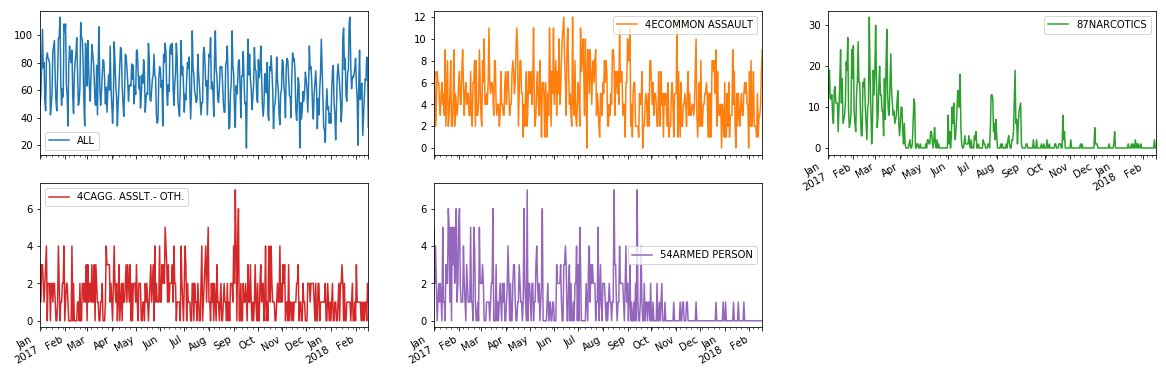

In [105]:
temporal_df.fillna(0).plot(subplots=True, layout=(3,3), figsize=(20,10))
print('time series')

# grid

In [129]:
from shapely.geometry import Point, box
import geopandas as gp
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot

In [110]:

def grid_line(mini, maxi, ngrid=10):
    delta = (maxi - mini) / ngrid
    return [(mini + i * delta, mini + (i + 1) * delta) for i in range(ngrid)]


def grid_area(w, s, e, n, ngrid=10):
    """
    grid area into ngrid^2 grids
    :param w, s, e, n,: the w, s, e, n (min_lon, min_lat, max_lon, max_lat) of the bound box
    :param ngrid: divide area into ngrid^2 grids
    :return: list of grid represented by bound box with s,w,n,e
    """
    grid_lat = grid_line(s, n, ngrid)
    grid_lon = grid_line(w, e, ngrid)
    grids = []
    for i in range(ngrid):
        for j in range(ngrid):
            si, ni = grid_lat[i]
            wj, ej = grid_lon[j]
            grids.append((wj, si, ej, ni))
    return grids

In [111]:
cityline = gp.read_file('raw/Baltcity_Line/baltcity_line.shp')
cityline.to_crs(epsg=3559, inplace=True)

In [112]:
print('longitude, latitude')
cityline.to_crs(epsg=4326)

longitude, latitude


,AREA,BOUNDARY_,BOUNDARY_I,ID,LENGTH,PERIMETER,Shape_Leng,geometry
0,2.562713e+09,2.0,0.0,0.0,207126.513,207126.51563,207126.513062,LINESTRING (-76.7112936699702 39.3719570306727...


In [116]:
gpdf_arrest = arrest[['Longitude', 'Latitude', 'IncidentOffense']]
gpdf_arrest = gpdf_arrest[~gpdf_arrest.Longitude.isnull()]
gpdf_arrest['geometry'] = gpdf_arrest.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
gpdf_arrest = gp.GeoDataFrame(gpdf_arrest.drop(['Longitude', 'Latitude'], axis=1), crs={'init': 'epsg:4326'})
gpdf_arrest.to_crs(cityline.crs, inplace=True)

In [119]:
line = cityline.geometry[0]
grids = grid_area(*line.bounds, ngrid=30)
wsen_poly = [box(*grid) for grid in grids]
wsen_poly = gp.GeoDataFrame(wsen_poly,columns=['geometry'], crs=cityline.crs)

In [121]:
joined = gp.sjoin(gpdf_arrest, wsen_poly)

In [123]:
wsen_poly = wsen_poly.join(joined.groupby('index_right').agg({'IncidentOffense': 'count'}).rename(columns={'IncidentOffense':'ALL'}), how='inner')

In [126]:
col = 'IncidentOffense'
for t in top4_type:
    wsen_poly = wsen_poly.join(
        joined[joined[col]==t].groupby('index_right').agg({'IncidentOffense': 'count'}).rename(columns={'IncidentOffense':t}))

In [127]:
wsen_poly.fillna(0, inplace=True)

0 0
0 1
0 2
1 0
1 1


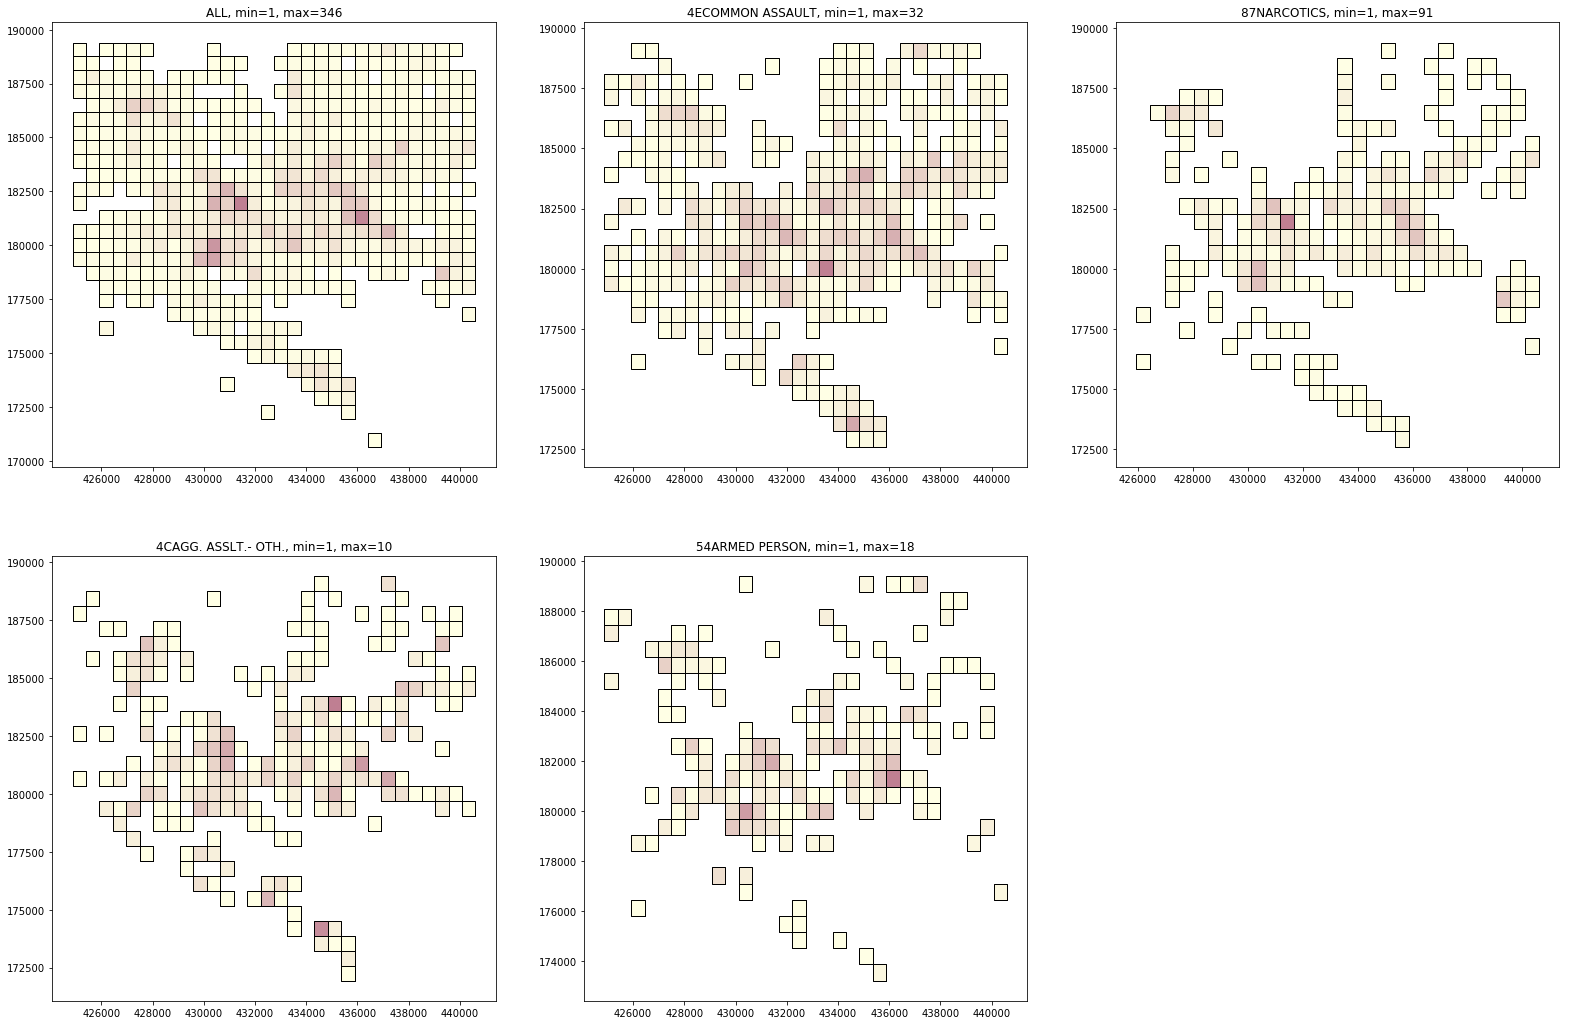

In [147]:

cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#ffffcc'), (1, '#800026')])
# fig, axes = pyplot.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(27, 18))
fig =pyplot.figure(figsize=(27,18))
for i, t in enumerate(['ALL'] + top4_type):
#     ax = axes[int(i/3)][i%3]
    print(int(i/3), i%3)
    ax = pyplot.subplot2grid((2,3), (int(i/3), i%3))
    mini, maxi = wsen_poly[wsen_poly[t]>0][t].min(), wsen_poly[t].max()
    ax.set_title('%s, min=%d, max=%d' % (t, mini, maxi))
    wsen_poly[wsen_poly[t]>0].plot(column=t, cmap=cmap, ax=ax, figsize=(9,9))
    